# Generating a ATL08 GeoParquet Store

This notebook creates a [GeoParquet](https://geoparquet.org/) store from scratch using a subset of [ICESat-2 ATL08](https://nsidc.org/data/atl08/versions/6) files. GeoParquet is built on [Apache Parquet](https://parquet.apache.org/) which is an open-source column-oriented file format which allows for efficient storage and retrieval using high performance compression.

The conversion functions are in the helpers file atl08_parquet_helpers which are functions originally written by Sean Harkins of Development Seed in https://github.com/developmentseed/icesat-parquet/.

:::{warning}
This work is experimental
:::

## 1. Install and import the necessary libraries

In [1]:
!pip install pyarrow geoarrow-pyarrow geopandas earthaccess==0.9.0 jupyterlab_vim

In [2]:
import atl08_parquet_helpers as aph
from datetime import datetime, timezone, timedelta
import earthaccess
import fsspec
import geopandas as gpd
from lonboard import viz
import os
import pyarrow.parquet as pq
from shapely import wkb

## 2. Login to earthaccess using [URS credentials](https://urs.earthdata.nasa.gov/home) and then setup an S3 client with credentials for NSIDC DAAC

In [ ]:
earthaccess.login()

aws_creds = earthaccess.get_s3_credentials(daac='NSIDC')

s3 = fsspec.filesystem(
    's3',
    anon=False,
    key=aws_creds['accessKeyId'],
    secret=aws_creds['secretAccessKey'],
    token=aws_creds['sessionToken'],
)

## 3. Search for a subset of ATL08 granules using the [earthaccess](https://github.com/nsidc/earthaccess) library

This search is only for 1 week for results over South America.

In [2]:
start = datetime(2021, 11, 1, tzinfo=timezone.utc)
end = start + timedelta(days=7)

results = earthaccess.search_data(
    short_name="ATL08",
    cloud_hosted=True,
    temporal=(start, end),
    bounding_box=(-90,-56,-32,14),
    count=-1
)
year_month = f"year={start.year}/month={start.month}"
week = 0
len(results)

Granules found: 79


79

## 4. Sort the results and setup the parquet

In [ ]:
sorted_results = sorted(results, key=lambda r : datetime.strptime(r['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime'], '%Y-%m-%dT%H:%M:%S.%fZ'))

template_file = s3.open(sorted_results[0].data_links(access="direct")[0], 'rb')

atl08_parquet = aph.ParquetTable(
    geometadata_file='atl08-parquet-metadata.json',
    template_file=template_file
)

## 5. Write results to the parquet table

Write results to 1 parquet file, using the year-month as a partition. Later on if we add more weeks we can add them to new parquet files and new partititions as appropriate.

In [23]:
%%time
# fetch a group and write them to a partition
directory="atl08_parquet"
os.makedirs(f"{directory}/{year_month}", exist_ok=True)
# i think it can only go one beam at a time even with more workers because of the global hdf5 interpreter lock
atl08_parquet.write_results_by_partition(sorted_results, s3, parquet_file=f"{directory}/{year_month}/{week}.parquet")

s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2021/11/01/ATL08_20211101004143_06041308_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2021/11/01/ATL08_20211101020858_06051307_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2021/11/01/ATL08_20211101021600_06051308_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2021/11/01/ATL08_20211101022303_06051309_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2021/11/01/ATL08_20211101022905_06051310_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2021/11/01/ATL08_20211101034316_06061307_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2021/11/01/ATL08_20211101135011_06121313_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2021/11/01/ATL08_20211101135613_06121314_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2021/11/01/ATL08_20211101140315_06131301_006_01.h5
s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2021/11/01/ATL08_20211101151647_06131312_

## We're done creating the parquet!

Now we can checkout the results.

In [3]:
dataset = pq.ParquetDataset("atl08_parquet", partitioning="hive", filters=[('year', '>=', 2021),
                                                     ('year', '<=', 2021),
                                                     ('month', '>=', 11),
                                                     ('month', '<=', 11)])
table = dataset.read(columns=["h_canopy", "geometry"])
df = table.to_pandas()
df['geometry'] = df['geometry'].apply(wkb.loads)


gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf

,h_canopy,geometry
0,1.745380e+01,POINT (-52.29471 -26.99078)
1,1.948102e+01,POINT (-52.29480 -26.98988)
2,2.134064e+01,POINT (-52.29490 -26.98898)
3,2.849182e+01,POINT (-52.29500 -26.98808)
4,4.165253e+01,POINT (-52.29510 -26.98719)
...,...,...
1871052,3.402823e+38,POINT (-44.20044 -1.67841)
1871053,3.402823e+38,POINT (-44.20053 -1.67751)
1871054,3.402823e+38,POINT (-44.20061 -1.67661)
1871055,3.402823e+38,POINT (-44.20070 -1.67571)


In [21]:
null_value = gdf['h_canopy'].max() 
gdf_filtered = gdf.loc[gdf['h_canopy'] != null_value]
gdf_filtered

,h_canopy,geometry
0,17.453796,POINT (-52.29471 -26.99078)
1,19.481018,POINT (-52.29480 -26.98988)
2,21.340637,POINT (-52.29490 -26.98898)
3,28.491821,POINT (-52.29500 -26.98808)
4,41.652527,POINT (-52.29510 -26.98719)
...,...,...
1870365,48.303154,POINT (-44.09986 -2.68297)
1870374,23.472631,POINT (-44.10197 -2.66132)
1870423,11.832104,POINT (-44.11124 -2.57115)
1870462,3.599800,POINT (-44.12907 -2.38984)


In [24]:
gdf_filtered['h_canopy'].min(), gdf_filtered['h_canopy'].max()

(0.769775390625, 149.9520263671875)

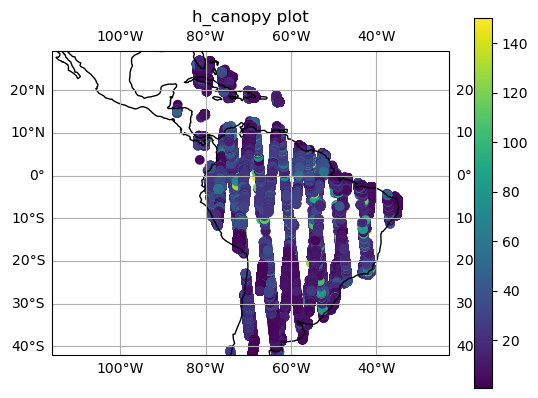

CPU times: user 45.4 s, sys: 620 ms, total: 46 s
Wall time: 45.4 s


In [25]:
%%time
# this will take too long and / or cause the kernel to die with large dataframes
# depending on your available memory
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs

crs = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw=dict(projection=crs))
gdf_filtered.plot(column='h_canopy', ax=ax, legend=True, cmap='viridis')
ax.set_extent([-116,-23,-32,21])
ax.set_title('h_canopy plot')

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines(draw_labels=True)

# Show plot
plt.show()

In [29]:
%%time
from lonboard import Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap
from palettable.colorbrewer.diverging import BrBG_10

layer = ScatterplotLayer.from_geopandas(gdf_filtered)
h_canopy = gdf_filtered['h_canopy']
layer.get_fill_color = apply_continuous_cmap(h_canopy, BrBG_10, alpha=0.7)

m = Map(layer)
m

CPU times: user 106 ms, sys: 16.2 ms, total: 122 ms
Wall time: 121 ms


Map(layers=[ScatterplotLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7fa69ee5c940>
[
  [
  …